In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader
import torch.optim.adam
from torchvision import datasets
from torchvision.transforms import v2
from PIL import Image
import pickle

import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# Set Device to CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [3]:
train_transforms = v2.Compose([
        # v2.RandomResizedCrop(224),
        # v2.RandomHorizontalFlip(),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        v2.Grayscale(num_output_channels=1),
        v2.PILToTensor(),
        v2.ToDtype(torch.float32),
        v2.Normalize([0.5], [0.5])
    ])

test_transforms = v2.Compose([
        # v2.Resize(256),
        # v2.CenterCrop(224),
        v2.Resize((32,32)),
        v2.Grayscale(num_output_channels=1),
        v2.PILToTensor(),
        v2.ToDtype(torch.float32),
        v2.Normalize([0.5], [0.5])
])

In [4]:
test_dir = ".\data\\Test"
train_dir = ".\data\\Train"

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

In [5]:
# Create a batch for images 
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [6]:
train_data

Dataset ImageFolder
    Number of datapoints: 900
    Root location: .\data\Train
    StandardTransform
Transform: Compose(
                 ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
                 Grayscale(num_output_channels=1)
                 PILToTensor()
                 ToDtype(scale=False)
                 Normalize(mean=[0.5], std=[0.5], inplace=False)
           )

In [7]:
test_data

Dataset ImageFolder
    Number of datapoints: 100
    Root location: .\data\Test
    StandardTransform
Transform: Compose(
                 Resize(size=[32, 32], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 Grayscale(num_output_channels=1)
                 PILToTensor()
                 ToDtype(scale=False)
                 Normalize(mean=[0.5], std=[0.5], inplace=False)
           )

In [8]:
for i, (X_train, Y_train) in enumerate(train_loader):
    break

In [9]:
Y_train.shape

torch.Size([10])

In [10]:
X_train.shape

torch.Size([10, 1, 32, 32])

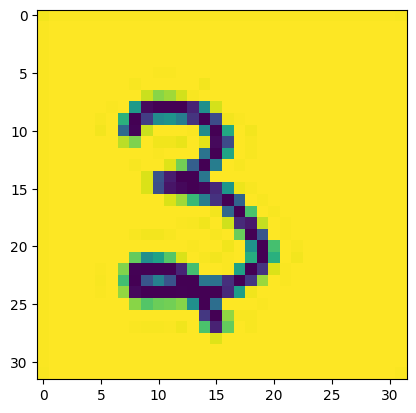

In [11]:
img = X_train[0][0].unsqueeze(0)
plt.imshow(img.squeeze())

In [12]:
labels_map = {
    0: "०",
    1: "१",
    2: "२",
    3: "३",
    4: "४",
    5: "५",
    6: "६",
    7: "७",
    8: "८",
    9: "९",
}

In [13]:
labels_map[int(Y_train[0])]

'३'

In [14]:
# Defining Model
conv1 = nn.Conv2d(1, 6, 3,1, padding=1)
conv2 = nn.Conv2d(6, 16, 3,1, padding=1)
conv3 = nn.Conv2d(16, 32, 3, 1, padding=1)


In [15]:
# Checking if it's working correctly
output1 = conv1(img)
output2 = conv2(output1)
output3 = conv3(output2)
print(f'Output shape after conv1: {output1.shape}, \nOutput shape after conv2: {output2.shape}, \nOutput shape after conv3: {output3.shape}')

# Perform our first convolution
img = F.relu(conv1(img))

Output shape after conv1: torch.Size([6, 32, 32]), 
Output shape after conv2: torch.Size([16, 32, 32]), 
Output shape after conv3: torch.Size([32, 32, 32])


In [16]:
# passing through pooling layer
image_tensor = F.max_pool2d(img, 2, 2) #kernel of 2 and stride of 2

In [17]:
image_tensor.shape

torch.Size([6, 16, 16])

In [18]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # First Convolutional Layer (1 channel for grayscale images)
        self.conv1 = nn.Conv2d(1, 6, 3, 1)  # input: 1 channel (grayscale), output: 6 channels, kernel size: 3
        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(6, 16, 3, 1)  # input: 6 channels, output: 16 channels, kernel size: 3
        self.conv3 = nn.Conv2d(16, 32, 3, 1)

        # Fully Connected Layers
        self.fc1 = nn.Linear(576, 300)  # Adjusted flattened size for grayscale image
        self.fc2 = nn.Linear(300, 150)
        self.fc3 = nn.Linear(150,10)  # Assuming 10 classes for classification

    def forward(self, X):
        # First Convolutional Layer + ReLU + Max Pooling
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)  # 2x2 kernel, stride 2

        # Second Convolutional Layer + ReLU + Max Pooling
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)  # 2x2 kernel, stride 2

        # Flatten the tensor before passing it to fully connected layers
        X = X.view(-1, 16 * 6 * 6)  # Flatten the output of the last convolutional layer

        # Fully Connected Layers + ReLU
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)  # No activation here because we'll use log_softmax at the output layer
        return F.log_softmax(X, dim=1)  # Apply log_softmax for multi-class classification


In [19]:
# Create an Instance of our model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=150, bias=True)
  (fc3): Linear(in_features=150, out_features=10, bias=True)
)

In [20]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [21]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 100
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened 2D
    loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False=0, sum those up
    trn_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print out some results
    if b%10 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # Test
  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away


  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0  Batch: 10  Loss: 2.839966297149658
Epoch: 0  Batch: 20  Loss: 2.3187155723571777
Epoch: 0  Batch: 30  Loss: 2.474181652069092
Epoch: 0  Batch: 40  Loss: 2.3574767112731934
Epoch: 0  Batch: 50  Loss: 2.2852652072906494
Epoch: 0  Batch: 60  Loss: 2.2203593254089355
Epoch: 0  Batch: 70  Loss: 2.3181698322296143
Epoch: 0  Batch: 80  Loss: 2.230185031890869
Epoch: 0  Batch: 90  Loss: 2.299591541290283
Epoch: 1  Batch: 10  Loss: 2.2689208984375
Epoch: 1  Batch: 20  Loss: 2.209549903869629
Epoch: 1  Batch: 30  Loss: 2.303093910217285
Epoch: 1  Batch: 40  Loss: 2.243744373321533
Epoch: 1  Batch: 50  Loss: 2.2965545654296875
Epoch: 1  Batch: 60  Loss: 2.3934245109558105
Epoch: 1  Batch: 70  Loss: 2.178555965423584
Epoch: 1  Batch: 80  Loss: 2.2320237159729004
Epoch: 1  Batch: 90  Loss: 2.1982336044311523
Epoch: 2  Batch: 10  Loss: 2.180380344390869
Epoch: 2  Batch: 20  Loss: 2.344975471496582
Epoch: 2  Batch: 30  Loss: 2.1680920124053955
Epoch: 2  Batch: 40  Loss: 2.263065814971924
Ep

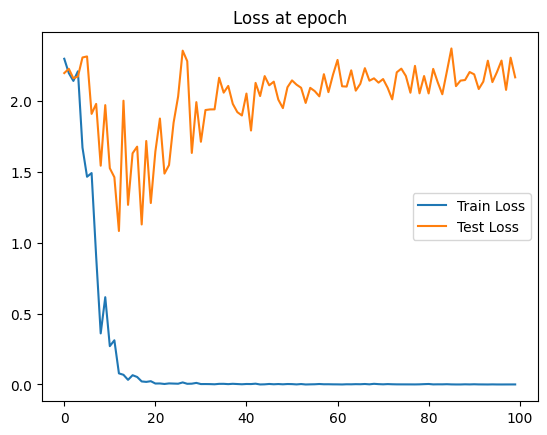

In [22]:
train_losses = [t1.item() for t1 in train_losses]

#  Graph the loss at epoch
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss' )
plt.title("Loss at epoch")
plt.legend()

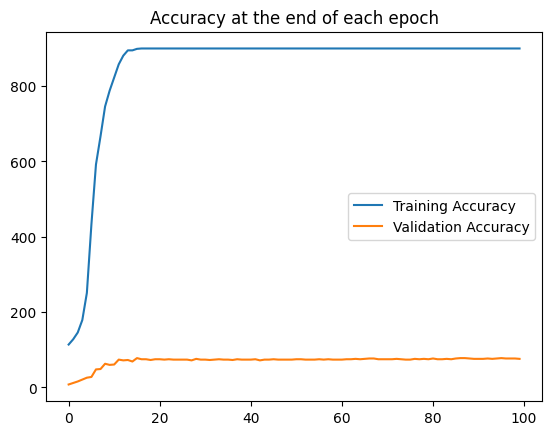

In [23]:
# Graph the accuracy at the end of epoch
plt.plot([t for t in train_correct], label = 'Training Accuracy')
plt.plot([t for t in test_correct], label = 'Validation Accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [24]:
test_load_evt = DataLoader(test_data, batch_size = 10, shuffle=False)

In [25]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_evt:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [26]:
# Did for correct
correct.item()/len(test_data)*100

76.0

In [27]:
# Grab the data
test_data[3][0].shape

torch.Size([1, 32, 32])

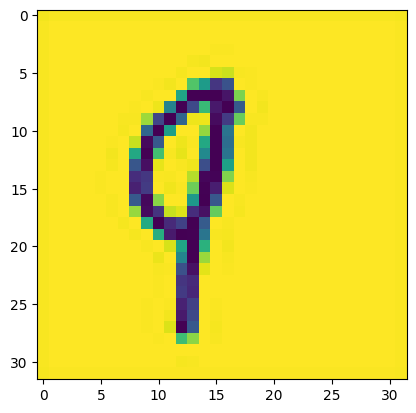

In [28]:
# Show the image
plt.imshow(test_data[11][0].permute(1, 2, 0))

In [29]:
# Pass the image through our model
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[11][0].view(1,32,32)) # batch size of 1, 1 color channel, 28x28 image
    

In [30]:
# check the new predictions 
new_prediction

tensor([[-30.0169,  -0.0987, -25.9456, -12.0846,  -8.0851,  -2.3678, -16.1465,
         -15.8885, -23.0147, -19.3433]])

In [31]:
new_prediction.argmax()

tensor(1)

In [32]:
from PIL import Image
# img = img.convert('RGB')

img = Image.open(r'.\\digit_dataset\\9_9.png')

img.show()

In [33]:
img_tensor = train_transforms(img)

In [34]:
img_tensor

tensor([[[509., 509., 509.,  ..., 509., 509., 509.],
         [509., 509., 509.,  ..., 509., 509., 509.],
         [509., 509., 509.,  ..., 509., 509., 509.],
         ...,
         [509., 509., 509.,  ..., 509., 509., 509.],
         [509., 509., 509.,  ..., 509., 509., 509.],
         [509., 509., 509.,  ..., 509., 509., 509.]]])

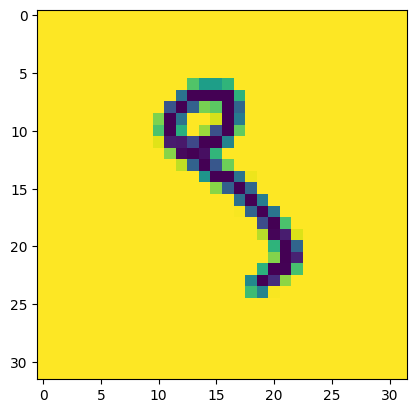

In [35]:
# plt.imshow(img_tensor.permute(1, 2, 0))
# test_img_tensor = test_img_tensor.view(1,1,32,32)

img = img_tensor.unsqueeze(0)
plt.imshow(img.squeeze())

In [36]:
model.eval()
with torch.no_grad():
    prediction = model(img_tensor) 

prediction

tensor([[-3.6309e+01, -1.3361e+01, -2.3110e+01, -1.1812e+01, -1.8903e+01,
         -2.1885e+01, -1.7480e+01, -3.0925e+01, -2.6565e+01, -8.9407e-06]])

In [37]:
prediction.argmax()

tensor(9)

In [38]:
labels_map[int(prediction.argmax())]

'९'

# Saving The Model

In [39]:
pickle.dump(model, open('final_model.sav', 'wb'))